In [1]:
%matplotlib inline
import json
import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 15)})

## Step 1: Data acquisition

### Legacy Pagecounts

set the start and end date for the pagecoutns API and construct the urls 

In [2]:
page_count_start_date = '2007120100' # 'YYYYMMDDHH'
page_count_end_date = '2016073100'

#Page count endpoints
mobile_counts_ep = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/de.wikipedia.org/mobile-site/monthly/{}/{}'.format(page_count_start_date, page_count_end_date)
destop_counts_ep = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/de.wikipedia.org/desktop-site/monthly/{}/{}'.format(page_count_start_date, page_count_end_date)


### Pageviews 

set the start and end date for the pageview API and construct the urls 

In [3]:
page_view_start_date = '2015070100'
page_view_end_date = '2018093000'

# page view endpoints
mobile_web_views_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/mobile-web/user/monthly/{}/{}'.format(page_view_start_date, page_view_end_date)
mobile_app_views_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/mobile-app/user/monthly/{}/{}'.format(page_view_start_date, page_view_end_date)
desktop_views_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikipedia.org/desktop/user/monthly/{}/{}'.format(page_view_start_date, page_view_end_date)


### Consolidate endpoint urls

In [4]:
file_names = [
    'pagecounts_mobile-site_200712-201607.json',
    'pagecounts_desktop-site_200712-201607.json',
    'pageviews_mobile-web-site_201507-201809.json',
    'pageviews_mobile-app-site_201507-201809.json',
    'pageviews_desktop-site_201507-201809.json',   
]

endpoint_urls = [ 
    mobile_counts_ep, 
    destop_counts_ep,
    mobile_web_views_url,
    mobile_app_views_url,
    desktop_views_url
]

### Get Json data from Endpoints

In [5]:
# Get data from the endpoints and store the json in .json files
for url, file_name in zip(endpoint_urls, file_names):
    http_response = requests.get(url)
    
    with open(file_name, 'w') as fd:
        fd.write(json.dumps(json.loads(http_response.content)))


## 2. Data Processing

In [6]:
def json_to_df(input_json_file):
    """ Convert the json file to a pandas dataframe and drop unnecessary columns
    """
    df = pd.read_json(input_json_file)
    df = json_normalize(df['items'])
    df.drop('granularity', axis=1, inplace=True)
    df.drop('project', axis=1, inplace=True)
    
    # Extract year and month
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y%m%d00")
    df['year'] = df['timestamp'].apply(lambda x: x.year)
    df['month'] = df['timestamp'].apply(lambda x : x.month)
    df.drop('timestamp', axis=1, inplace=True)
    
    return df

Read the json file created in the previous steps for PageCounts and select count, year and month columns

In [7]:
pagecount_mobile = json_to_df('pagecounts_mobile-site_200712-201607.json',)[['count', 'year', 'month']]
pagecount_desktop = json_to_df('pagecounts_desktop-site_200712-201607.json',)[['count', 'year', 'month']]

Read the json file created in the previous steps for Pageviews and select views, year and month columns

In [8]:
pageview_web = json_to_df('pageviews_mobile-web-site_201507-201809.json')
pageview_mobile = json_to_df('pageviews_mobile-app-site_201507-201809.json',)
pageview_desktop = json_to_df('pageviews_desktop-site_201507-201809.json',)

pageview_web = pageview_web[pageview_web['agent'] == 'user'][['views', 'year', 'month']]
pageview_mobile = pageview_mobile[pageview_mobile['agent'] == 'user'][['views', 'year', 'month']]
pageview_desktop = pageview_desktop[pageview_desktop['agent'] == 'user'][['views', 'year', 'month']]

Rename the count and views columns to what they actually represent

In [9]:
pagecount_mobile.rename(columns={'count' : 'pagecount_mobile_views'}, inplace=True)
pagecount_desktop.rename(columns={'count' : 'pagecount_desktop_views'}, inplace=True)
pageview_web.rename(columns={'views' : 'pageview_web_views'}, inplace=True)
pageview_mobile.rename(columns={'views' : 'pageview_mobile_views'}, inplace=True)
pageview_desktop.rename(columns={'views' : 'pageview_desktop_views'}, inplace=True)

## Merge the dataframes

Merge/Join all the 5 dataframes created in the previous step on 'year' and 'month' column. Sort the rows using these column values

In [10]:
combined_df = pagecount_mobile.merge(pagecount_desktop, 
                                            left_on=['year', 'month'], right_on=['year', 'month'], 
                                            how='outer', sort=True)

combined_df = combined_df.merge(pageview_web, 
                                            left_on=['year', 'month'], right_on=['year', 'month'], 
                                            how='outer', sort=True)

combined_df = combined_df.merge(pageview_mobile, 
                                            left_on=['year', 'month'], right_on=['year', 'month'], 
                                            how='outer', sort=True)

combined_df = combined_df.merge(pageview_desktop, 
                                            left_on=['year', 'month'], right_on=['year', 'month'], 
                                            how='outer', sort=True)


In [11]:
combined_df.head()

,pagecount_mobile_views,year,month,pagecount_desktop_views,pageview_web_views,pageview_mobile_views,pageview_desktop_views
0,NaN,2007,12,469835842.0,NaN,NaN,NaN
1,NaN,2008,1,863575077.0,NaN,NaN,NaN
2,NaN,2008,2,805618770.0,NaN,NaN,NaN
3,NaN,2008,3,821957233.0,NaN,NaN,NaN
4,NaN,2008,4,844357513.0,NaN,NaN,NaN


Create 2 additional columns that sum up the mobile and desktop views

In [12]:
combined_df['pagecount_all_views'] = combined_df['pagecount_desktop_views'] + combined_df['pagecount_mobile_views']
combined_df['pageview_all_views'] = combined_df['pageview_web_views'] + combined_df['pageview_mobile_views'] + \
                                    combined_df['pageview_desktop_views']

## Generate final dataframe

Select only the required fields from the combined fields to create a new dataframe called aggregate_df

In [13]:

aggregated_df = combined_df[['year', 'month', 
                             'pagecount_all_views',
                             'pagecount_desktop_views', 
                             'pagecount_mobile_views',
                             'pageview_all_views',
                             'pageview_desktop_views',
                             'pageview_mobile_views']]

In [14]:
aggregated_df.head() 

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,NaN,469835842.0,NaN,NaN,NaN,NaN
1,2008,1,NaN,863575077.0,NaN,NaN,NaN,NaN
2,2008,2,NaN,805618770.0,NaN,NaN,NaN,NaN
3,2008,3,NaN,821957233.0,NaN,NaN,NaN,NaN
4,2008,4,NaN,844357513.0,NaN,NaN,NaN,NaN


### Save the aggregated dataframe in a csv file

In [15]:
aggregated_df.to_csv('en-wikipedia_traffic_200712-201809.csv',index=False)

## Analysis

Read the CSV file into a data frame

In [16]:
aggregated_df = pd.read_csv('en-wikipedia_traffic_200712-201809.csv')

In [17]:
aggregated_df.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,NaN,469835842.0,NaN,NaN,NaN,NaN
1,2008,1,NaN,863575077.0,NaN,NaN,NaN,NaN
2,2008,2,NaN,805618770.0,NaN,NaN,NaN,NaN
3,2008,3,NaN,821957233.0,NaN,NaN,NaN,NaN
4,2008,4,NaN,844357513.0,NaN,NaN,NaN,NaN


Convert month values to string. Prefix single digit values with zero

In [18]:
aggregated_df['month'] = aggregated_df['month'].astype(str)
aggregated_df['month'] = aggregated_df['month'].apply(lambda x : '0' + x if x not in ('10', '11', '12') else x)

date_x = aggregated_df.apply(lambda x : str(int(x['year'])) + "-" + str((x['month'])), axis='columns')
aggregated_df['date'] = date_x

## Plot the time series data

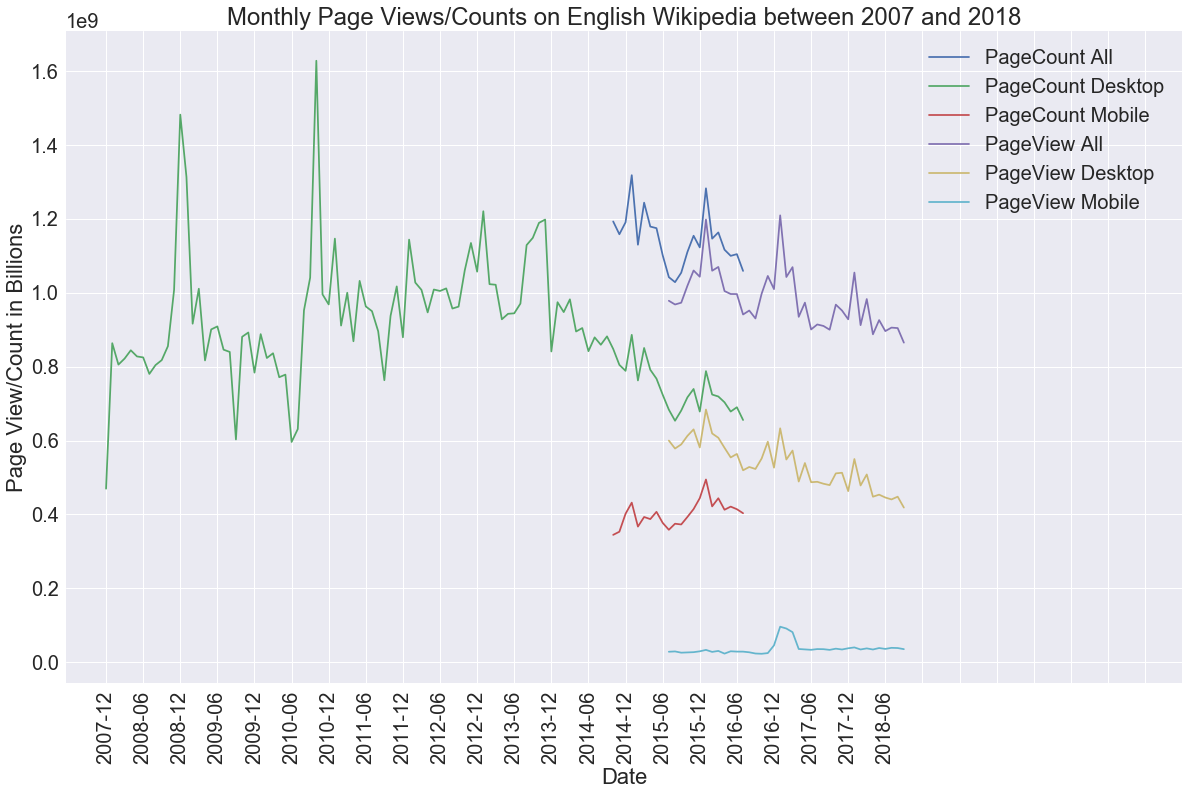

In [19]:
sns.set(rc={'figure.figsize':(20, 12)})
sns.set(font_scale=2)

plt.plot(aggregated_df['date'], aggregated_df['pagecount_all_views'])
plt.plot(aggregated_df['date'], aggregated_df['pagecount_desktop_views'])
plt.plot(aggregated_df['date'], aggregated_df['pagecount_mobile_views'])
plt.plot(aggregated_df['date'], aggregated_df['pageview_all_views'])
plt.plot(aggregated_df['date'], aggregated_df['pageview_desktop_views'])
plt.plot(aggregated_df['date'], aggregated_df['pageview_mobile_views'])

plt.xticks(rotation='vertical')
plt.legend(['PageCount All', 'PageCount Desktop', 'PageCount Mobile', 
            'PageView All', 'PageView Desktop', 'PageView Mobile'])
plt.xticks(np.arange(0, 180, step=6))

plt.xlabel('Date')
plt.ylabel('Page View/Count in Billions')
plt.title('Monthly Page Views/Counts on English Wikipedia between 2007 and 2018')

plt.show()